# Hypertrophic Cardiomyopathy Genes Cross-Validation
##### Selin Kubali

## Goal
Choose a threshold to differentiate high-risk and low-risk individuals for HCM, where such a threshold is appropriate.

 
#### How the code functions
Cross-validation is done on patient information and builds a model which predicts how likely each patient is to develop HCM. The code then runs through 100 possibilities for splitting the patient data into low- and high-risk groups, from 1%/99% to 99%/1%. The best threshold is chosen based on p-values and F1 scores and the data is run once more with the chosen threshold and the results plotted against variant pathogenicity data from Clinvar.
Cross-validation is done by splitting on variant data, to ensure there are an equal number of variants in each fold and prevent overfitting on high-frequency variants.


#### Inputs
Lifelines files - Stored in */selected_genes/hcm/cox_model_data*. 
Variant data files - Stored in */selected_genes/hcm/variant_files*.
Clinvar data - Stored in */selected_genes/hcm/csv_files/variant_summary.txt*

#### Load packages

In [1]:
!pip install lifelines --quiet --root-user-action=ignore
!pip install scikit-learn --quiet --root-user-action=ignore
!pip install matplotlib --quiet --root-user-action=ignore
!pip install statsmodels --quiet --root-user-action=ignore
!pip install seaborn --quiet --root-user-action=ignore

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings

from lifelines import plotting
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

from statsmodels.stats.multitest import multipletests
from scipy.stats import percentileofscore
from matplotlib import rcParams

plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore")

### Extract ClinVar information

In [4]:
!dx download /selected_genes/hcm/csv_files/variant_summary.txt.gz

[===========================================================>] Completed 276,060,790 of 276,060,790 bytes (100%) /opt/notebooks/variant_summary.txt.gzz


In [5]:
!gzip -d variant_summary.txt.gz

In [3]:
def cross_val(gene, no_variant_info = False, only_variant_info = False):
        """ Load variant data, individual patient data, and clinvar data. Runs cross-validation on individual patient data to predict risk of developing HCM. Cleans and joins files and returns a file with individual patient data, individual patient hazard scores, and clinvar pathogenicity data.
        """


        cph = CoxPHFitter(penalizer = 0.001)
        
        
        
        # load lifelines file
        lifelines_data = pd.read_csv(f'/mnt/project/selected_genes/hcm/cox_model_data/{gene}_with_generated_data.csv', 
                                     dtype = {'duration':'float', 'is_CM':'boolean', 'sex':'boolean',
                                              'is_family_hist':'boolean', 'is_AF':'boolean',
                                              'is_HTN': 'boolean', 'am_pathogenicity':'float'})
        
        lifelines_data['prs_score'] = (lifelines_data['prs_score'] - lifelines_data['prs_score'].min()) / (lifelines_data['prs_score'].max() - lifelines_data['prs_score'].min())     
        lifelines_data['am_pathogenicity'] = (lifelines_data['am_pathogenicity'] - lifelines_data['am_pathogenicity'].min()) / (lifelines_data['am_pathogenicity'].max() - lifelines_data['am_pathogenicity'].min())     
        lifelines_data = lifelines_data[lifelines_data['Consequence'].isin(['synonymous_variant','deleterious','missense_variant'])]
        lifelines_data.loc[lifelines_data['Consequence'] == 'deleterious', 'am_pathogenicity'] = 1
        lifelines_data.loc[lifelines_data['Consequence'] == 'synonymous_variant', 'am_pathogenicity'] = 0

        
        variant_level_features = ['am_pathogenicity', 'revel_max','spliceai_ds_max']
        if 'revel_max' not in lifelines_data.columns:
            variant_level_features = ['am_pathogenicity','spliceai_ds_max']
            
        demographic_level_features = ['is_HTN', 'is_AF', 'prs_score', 'sex', 'is_family_hist']
        if only_variant_info == True:
            lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features]

        elif no_variant_info == True:
            lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + demographic_level_features]
        else:
            lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features + demographic_level_features]



        
        # load variant data file
        variant_data = pd.read_csv(f'/mnt/project/selected_genes/hcm/variant_files/{gene}_variants.csv')
        variant_data_name = variant_data[['Name']]

        # set lifelines data index to variant data index
        variant_data_name['var_index'] = variant_data_name.index
        lifelines_data = variant_data_name.merge(lifelines_data, how="outer")
        lifelines_data.set_index("var_index")
        lifelines_data=lifelines_data.dropna()


        # load, clean, and merge clinvar information
        clinvar_df = pd.read_csv('variant_summary.txt', sep = '\t', dtype = {'Chromosome':'str'})
        clinvar_df = clinvar_df[clinvar_df['Assembly'] == 'GRCh38']
        clinvar_df = clinvar_df.rename(columns={"Chromosome": "Chrom", "Start": "Pos", "ReferenceAlleleVCF": "Ref", "AlternateAlleleVCF": "Alt"})
        clinvar_df = clinvar_df[["Name", "Chrom", "Pos", "Ref", "Alt", "ClinicalSignificance"]]
        clinvar_variant_df = pd.merge(variant_data, clinvar_df, how = 'left', on = ['Pos', 'Ref', 'Alt'])
        clinvar_variant_df = clinvar_variant_df.rename(columns={"Name_x": "Name"})
        clinvar_variant_df = clinvar_variant_df[["Name", "ClinicalSignificance"]]
        lifelines_data = pd.merge(clinvar_variant_df, lifelines_data, how="right", on = ['Name'])
        
        # cross validation: split up phenotypic data file based on variant file index
        kf = KFold(n_splits=5, shuffle=True, random_state=4)
        testing_set = []
        for train_idx, test_idx in kf.split(variant_data):
            
                
                
                train = lifelines_data[lifelines_data['var_index'].isin(train_idx)]
                test = lifelines_data[lifelines_data['var_index'].isin(test_idx)]

                train = train.drop(['var_index'], axis=1)
                test = test.drop(['var_index'], axis=1)

                # fit CPH and add hazard scores
                if only_variant_info == True:
                    cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features)
                elif no_variant_info == True:
                    cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = demographic_level_features)
                else:
                    cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features + demographic_level_features)

                hazard_scores_fold = cph.predict_partial_hazard(test)
                test['hazard'] = hazard_scores_fold
                testing_set.append(test)
         

                
        # create new lifelines_data df by joining all testing sets
        lifelines_data = pd.concat([df for idx, df in enumerate(testing_set)]) 
    
    
        return lifelines_data
    



#### Run CoxPH cross-validation
# revise here
Remove synonymous variants, split the dataset in five, and for each split dataset, predict the likelihood of developing HCM based on hazard score, calculate the maximum Youden index, and find the corresponding threshold. Choose the final threshold by taking the average of the five thresholds calculated.

Only genes with at least 10 HCM cases in their dataset are used. 



In [37]:
def find_threshold_vals(genes, no_variant_info = False, only_variant_info = False):
    
        """ Runs CoxPH cross-validation with the chosen threshold for a gene."""

    
        for gene in genes:
            print(gene)

                
            # running cross-validation
            if only_variant_info == True:
                print("Model with only variant-level features")
                lifelines_data = cross_val(gene, only_variant_info = True)
            elif no_variant_info == True: 
                lifelines_data = cross_val(gene, no_variant_info = True)
            else:
                print("Model with all features")
                lifelines_data = cross_val(gene)
            if no_variant_info == True:
                lifelines_data = lifelines_data.drop(['am_pathogenicity'], axis = 1)
            
            lifelines_data_synonymous = lifelines_data[(lifelines_data['am_pathogenicity'] == 0)]
            lifelines_data = lifelines_data[(lifelines_data['am_pathogenicity'] != 0)]

            if len(lifelines_data[lifelines_data['is_HCM'] == 1]) >= 10:

                kf = KFold(n_splits=5, shuffle=True, random_state=4)
                testing_set = []
                threshold_list = []
                lifelines_data['is_HCM'] = lifelines_data['is_HCM'].astype('int64')



                hazard = None
                for train_idx, test_idx in kf.split(lifelines_data):
                    train = lifelines_data[lifelines_data.index.isin(train_idx)]
                    fpr, tpr, thresholds = metrics.roc_curve(train['is_HCM'], train['hazard'], pos_label = 1)
                    roc_auc = metrics.auc(fpr, tpr)
                    sensitivity = tpr
                    specificity = 1 - fpr
                    youden_index = sensitivity + specificity - 1
                    optimal_idx = np.argmax(youden_index)
                    hazard = thresholds[optimal_idx]
                    threshold = int(percentileofscore(train['hazard'], hazard))
                    threshold_list.append(threshold)
                print("Threshold list: ", threshold_list)
                threshold = sum(threshold_list)/len(threshold_list)
                vus_kmf_graph(gene, threshold, lifelines_data, lifelines_data_synonymous, hazard)
            else:
                print("Too few cases")



                


#### Convert scores to dataframe

In [38]:
def vus_kmf_graph(gene, threshold, lifelines_data, lifelines_data_synonymous, hazard):
    """Graph hazard scores against synonymous variants and benign, VUS, and pathogenic Clinvar variants. 
    Patients carrying VUS variants are divided by the chosen threshold and plotted on Kaplan-Meier curves."""
    
    
    lifelines_data_pathogenic = lifelines_data[(lifelines_data['ClinicalSignificance'].isin(['Pathogenic', 'Pathogenic/Likely pathogenic', 'Likely pathogenic']))]
    lifelines_data_benign = lifelines_data[(lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign']))]
    lifelines_data_vus = lifelines_data[~lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign', 'Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic', 'Conflicting interpretations of pathogenicity'])]
    


    # Compare patients above threshold with patients below threshold
    bottom = lifelines_data[lifelines_data['hazard'] < hazard]
    top = lifelines_data[lifelines_data['hazard'] >= hazard]

    try:
        dfA = pd.DataFrame({'E': bottom['is_HCM'], 'T': bottom['duration'], 'is_highest': 0})
        dfB = pd.DataFrame({'E': top['is_HCM'], 'T': top['duration'], 'is_highest': 1})
        df = pd.concat([dfA, dfB])
        cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
        results = "{:.{}g}".format(cph.summary['p'].at['is_highest'], 2)
    except:
        print("Convergence did not fit")

    print('Number of HCM cases in non-synonymous:', len(lifelines_data[lifelines_data['is_HCM'] == 1]))
    print('Threshold by percentile: ', threshold)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(gene, fontsize=28, y = 1)

    # KMF graphs for all patients with non-synonymous variants
    kmf_top = KaplanMeierFitter(label = 'High risk')
    kmf_top.fit(top['duration'], top['is_HCM'])
    kmf_top.plot(ax=axs[0], color = '#CC79A7') 
        
    kmf_bottom = KaplanMeierFitter(label = 'Low risk')
    kmf_bottom.fit(bottom['duration'], bottom['is_HCM'])
    kmf_bottom.plot(ax=axs[0], color = '#009E73')
    axs[0].text(0.02, 0.92,'p-value: '+str(results), transform=axs[0].transAxes, backgroundcolor = 'white', fontsize = 11)
    axs[0].set_xlim(0, 80)
    axs[0].set_title('Low and high risk for all patients')
    axs[0].set_ylabel('Percent without HCM')
    axs[0].set_xlabel('Age')
    plotting.add_at_risk_counts(kmf_bottom, kmf_top , ax = axs[0], rows_to_show = ['At risk'], xticks = [40, 60, 80])

    
    # KMF graphs for patients with VUS only 
    lifelines_data_vus_low = lifelines_data_vus[lifelines_data_vus['hazard'] < hazard]
    lifelines_data_vus_high = lifelines_data_vus[lifelines_data_vus['hazard'] > hazard]


    kmf_vus_high = KaplanMeierFitter(label = 'VUS high risk')
    kmf_vus_high.fit(lifelines_data_vus_high['duration'], lifelines_data_vus_high['is_HCM'])
    kmf_vus_high.plot(ax=axs[1], color = '#CC79A7') 


    dfA = pd.DataFrame({'E': lifelines_data_vus_low['is_HCM'], 'T': lifelines_data_vus_low['duration'], 'is_highest': 0})
    dfB = pd.DataFrame({'E': lifelines_data_vus_high['is_HCM'], 'T': lifelines_data_vus_high['duration'], 'is_highest': 1})
    df = pd.concat([dfA, dfB])
    cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
    results = "{:.{}g}".format(cph.summary['p'].at['is_highest'], 2)


    kmf_vus_low = KaplanMeierFitter(label = 'VUS low risk')
    kmf_vus_low.fit(lifelines_data_vus_low['duration'], lifelines_data_vus_low['is_HCM'])
    kmf_vus_low.plot(ax=axs[1], color = '#009E73')
    axs[1].text(0.02, 0.92,'p-value: '+str(results), transform=axs[1].transAxes, backgroundcolor = 'white', fontsize = 11)
    axs[1].set_xlim(0, 80)
    axs[1].set_title('Low and high risk VUS variant patients')
    axs[1].set_ylabel('Percent without HCM')
    axs[1].set_xlabel('Age')
    plotting.add_at_risk_counts(kmf_vus_low, kmf_vus_high, ax = axs[1], rows_to_show = ['At risk'], xticks = [40, 60, 80])

    print('Number of VUS above threshold: ', len(lifelines_data_vus[lifelines_data_vus['hazard'] > hazard]))

    # Box plots by hazard score for patient with synonymous, benign, VUS, and pathogenic variants
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.set_style("ticks")
    data = [lifelines_data_pathogenic['hazard'], lifelines_data_vus['hazard'], lifelines_data_benign['hazard'], lifelines_data_synonymous['hazard']]
    boxplot = axs.boxplot(data, patch_artist=True, vert=0)
    axs.set_yticklabels(['P/LP'+'\n'+'n='+str(len(lifelines_data_pathogenic)), 'VUS'+'\n'+'n='+str(len(lifelines_data_vus)), 'B/LB'+'\n'+'n='+str(len(lifelines_data_benign)), 'Syn'+'\n'+'n='+str(len(lifelines_data_synonymous))])
    axs.get_xaxis().tick_bottom()
    axs.get_yaxis().tick_left()
    axs.axvline(hazard, color='#fb8072', linestyle='--', label = 'Threshold')
    axs.legend(loc = 'lower right')
    axs.set_xlabel("Hazard score")
    axs.set_ylabel("Clinvar variant pathogenicity")
    axs.set_title("Hazard score by Clinvar pathogenicity")
    colors = ['#8cc5e3', '#4a2377','#0d7d87', 'lightgreen']
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.show()
        

    
    return threshold

ACTC1
Model with only variant-level features
Too few cases
ACTN2
Model with only variant-level features
Threshold list:  [91, 40, 26, 40, 80]
Number of HCM cases in non-synonymous: 13
Threshold by percentile:  55.4
Number of VUS above threshold:  1818


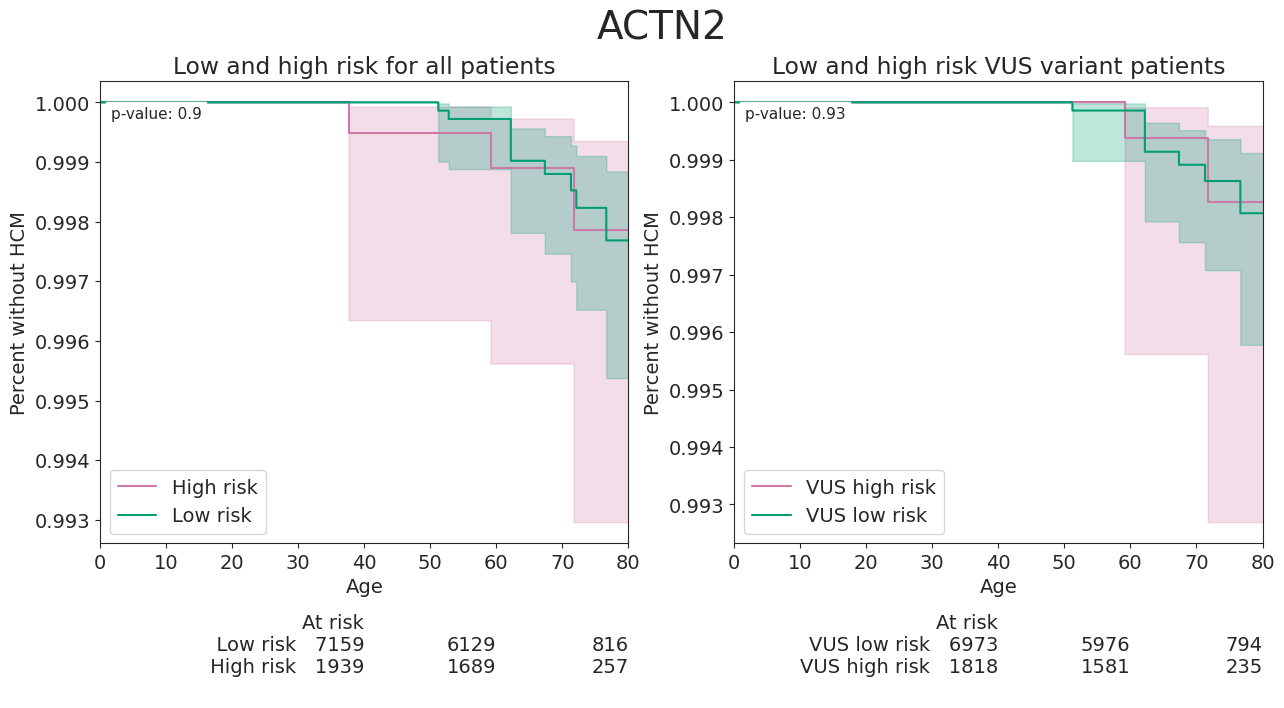

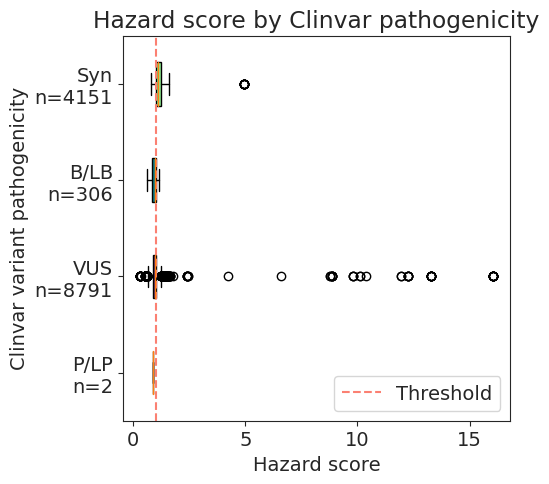

ALPK3
Model with only variant-level features
Threshold list:  [82, 87, 82, 81, 87]
Number of HCM cases in non-synonymous: 78
Threshold by percentile:  83.8
Number of VUS above threshold:  4219


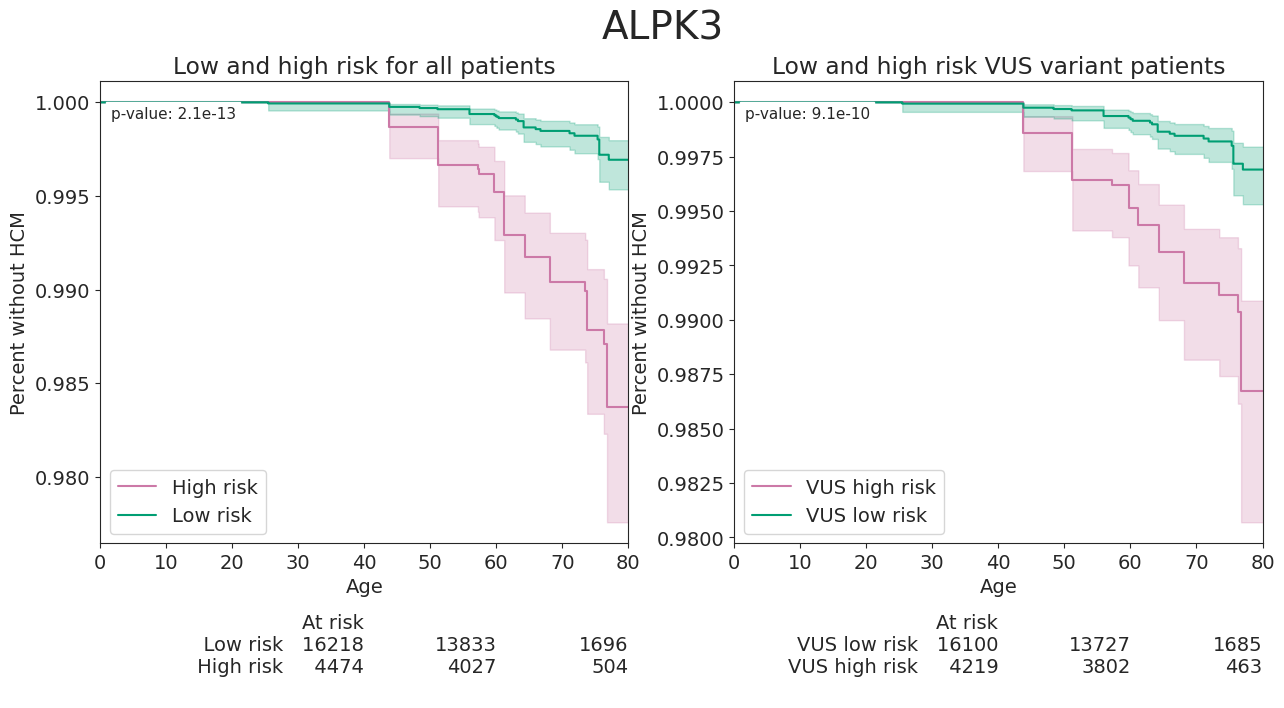

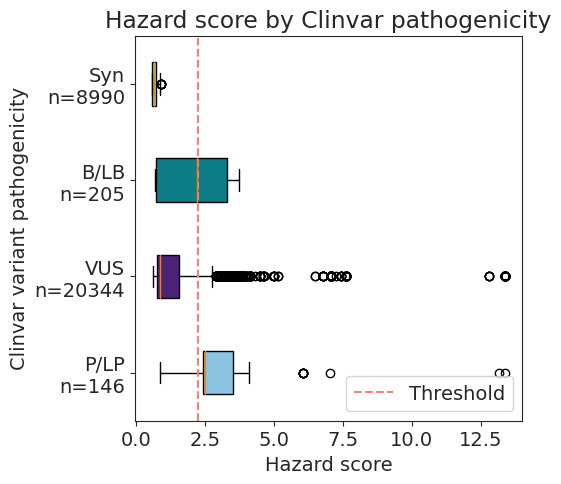

CSRP3
Model with only variant-level features
Threshold list:  [78, 78, 78, 78, 61]
Number of HCM cases in non-synonymous: 10
Threshold by percentile:  74.6
Number of VUS above threshold:  1292


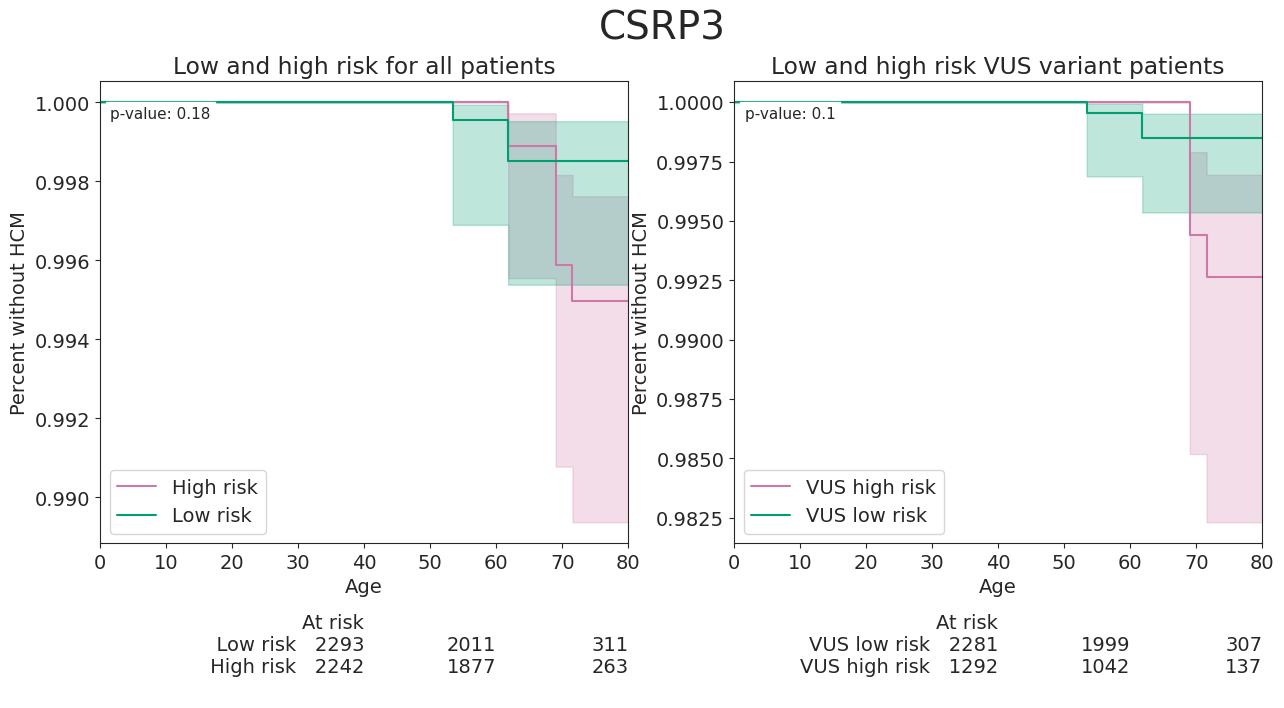

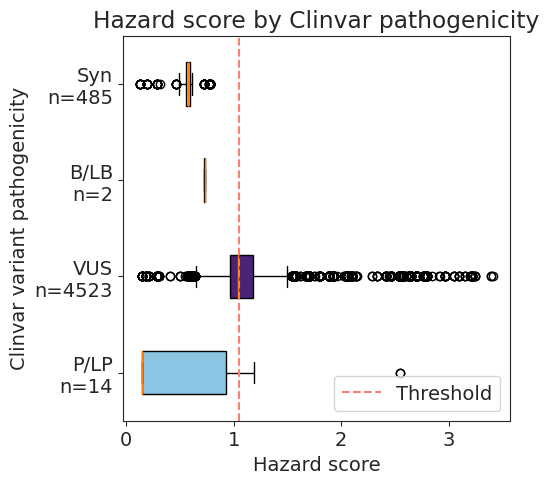

DES
Model with only variant-level features
Too few cases
FHOD3
Model with only variant-level features
Threshold list:  [34, 33, 34, 34, 35]
Number of HCM cases in non-synonymous: 35
Threshold by percentile:  34.0
Number of VUS above threshold:  7597


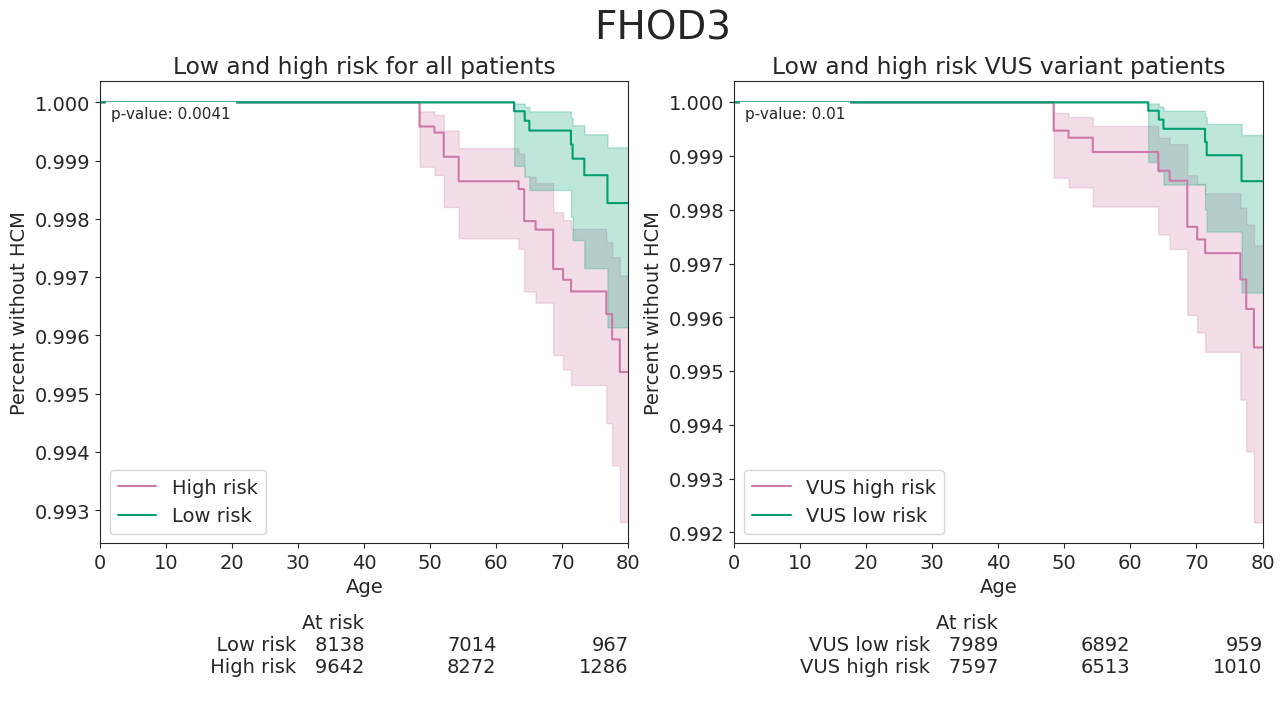

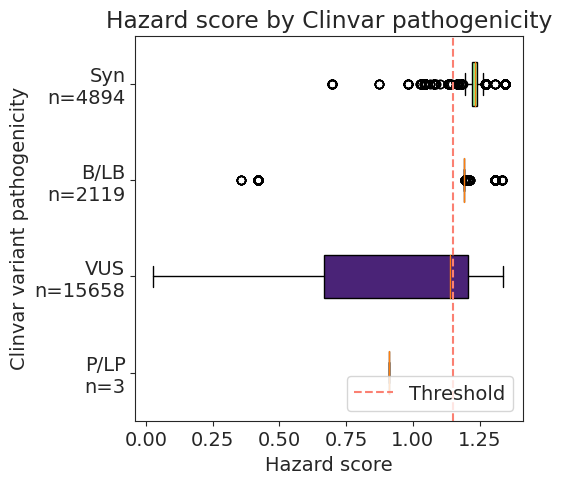

FLNC
Model with only variant-level features
Threshold list:  [57, 58, 57, 58, 58]
Number of HCM cases in non-synonymous: 62
Threshold by percentile:  57.6
Number of VUS above threshold:  5893


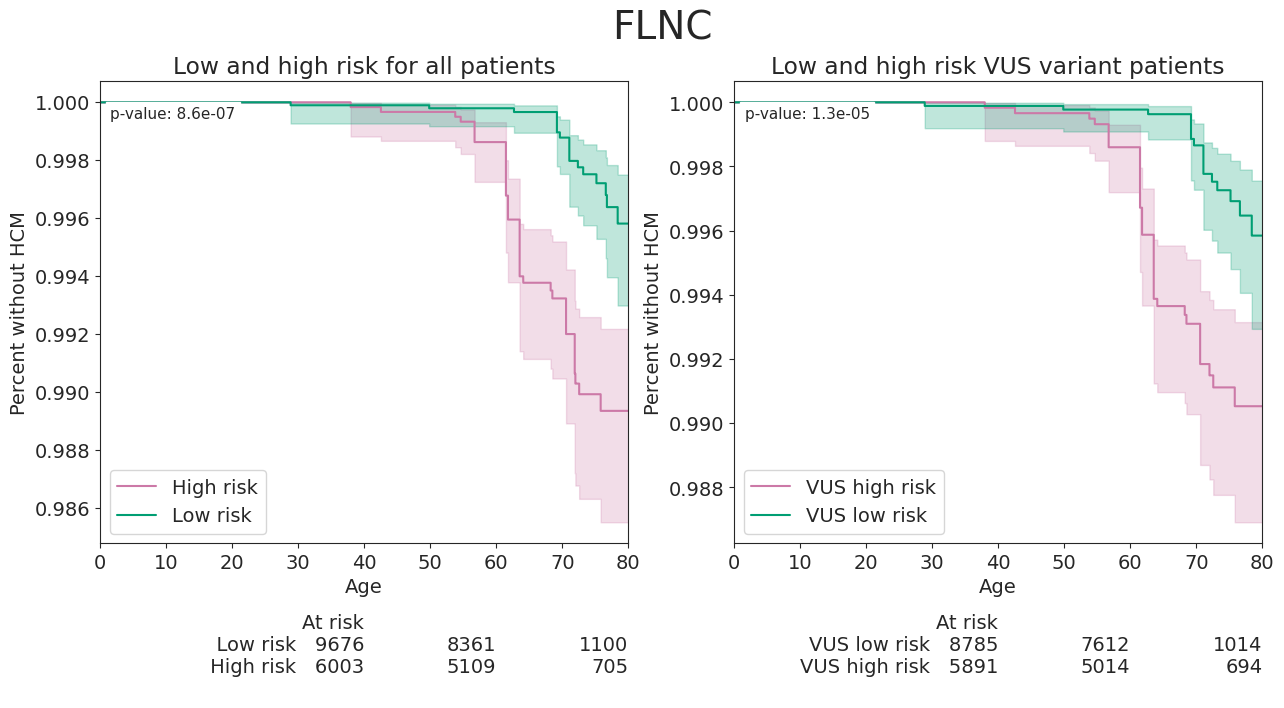

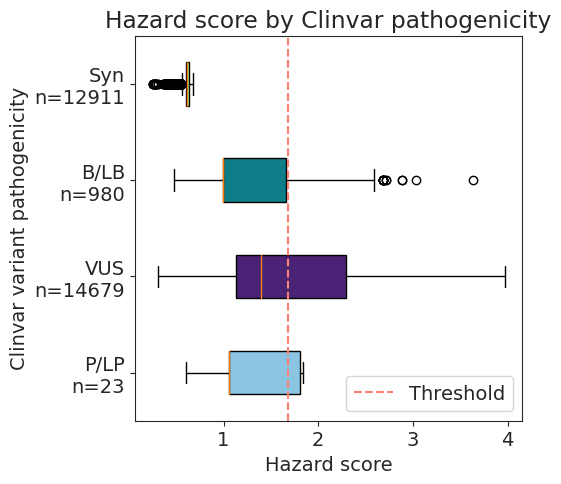

JPH2
Model with only variant-level features
Too few cases
MYBPC3
Model with only variant-level features
Threshold list:  [87, 87, 87, 87, 87]
Number of HCM cases in non-synonymous: 325
Threshold by percentile:  87.0
Number of VUS above threshold:  4217


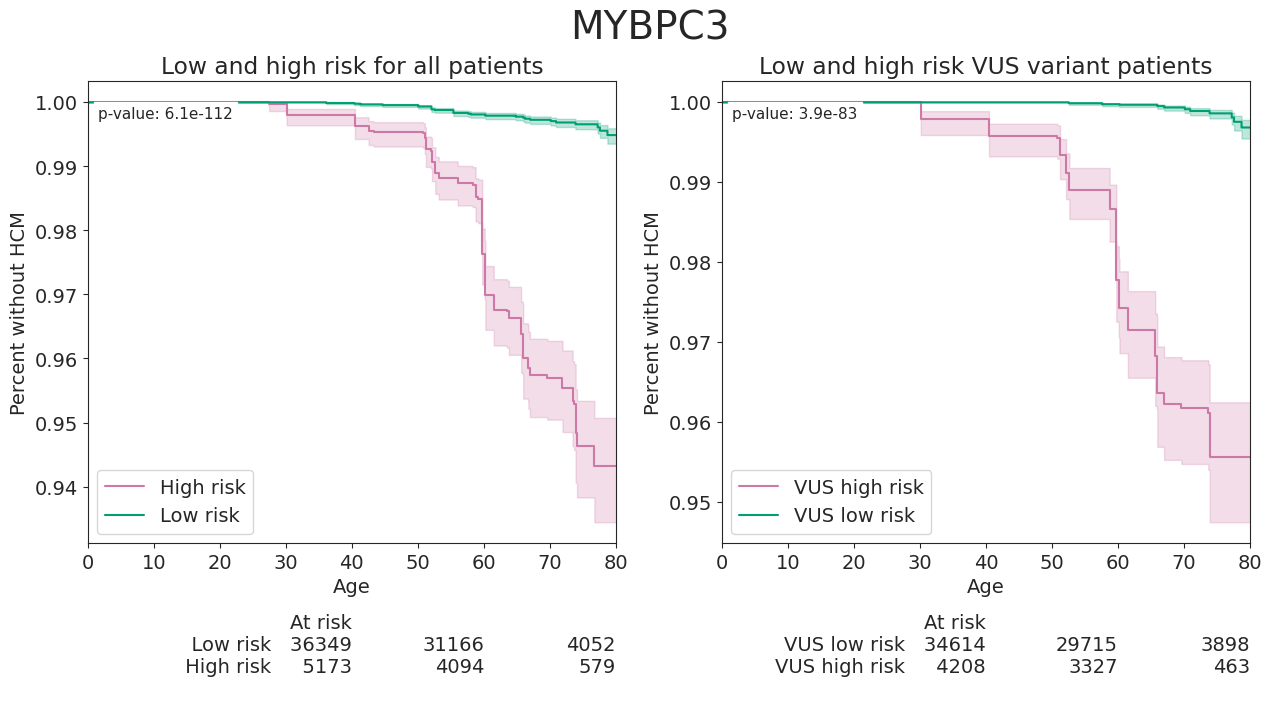

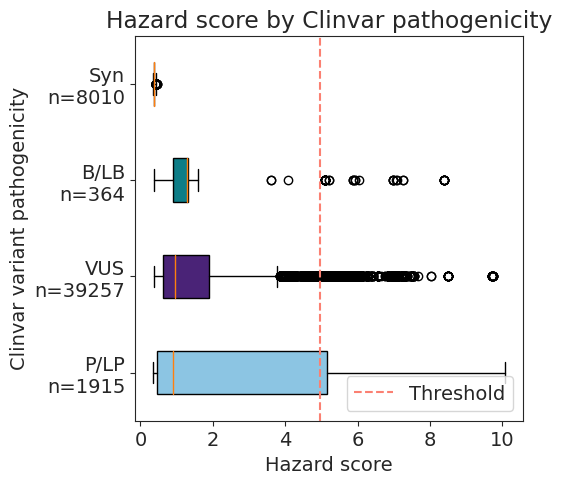

MYH6
Model with only variant-level features
Threshold list:  [22, 35, 22, 22, 22]
Number of HCM cases in non-synonymous: 25
Threshold by percentile:  24.6
Number of VUS above threshold:  13126


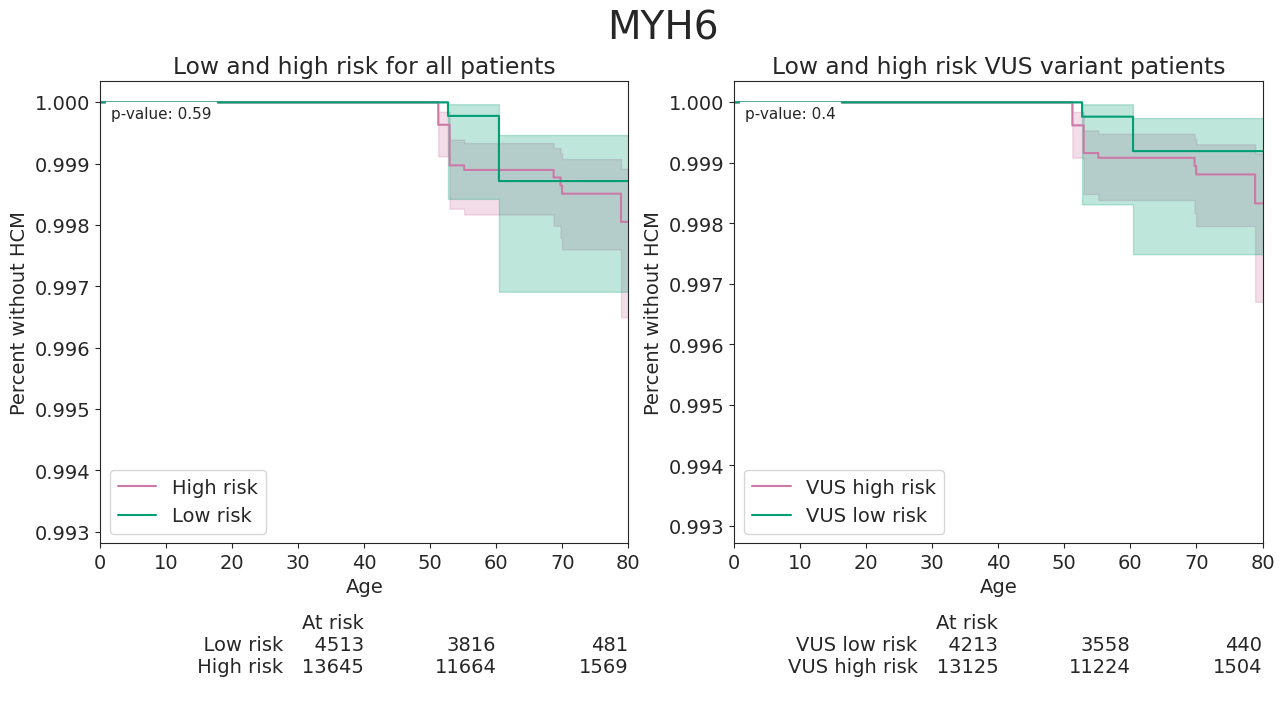

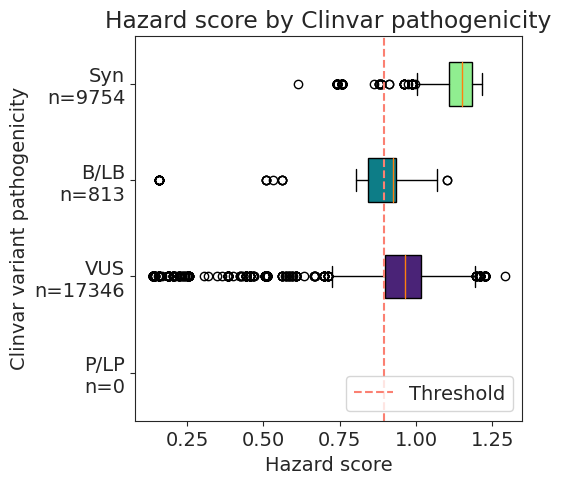

MYH7
Model with only variant-level features
Threshold list:  [12, 7, 12, 8, 8]
Number of HCM cases in non-synonymous: 117
Threshold by percentile:  9.4
Number of VUS above threshold:  8157


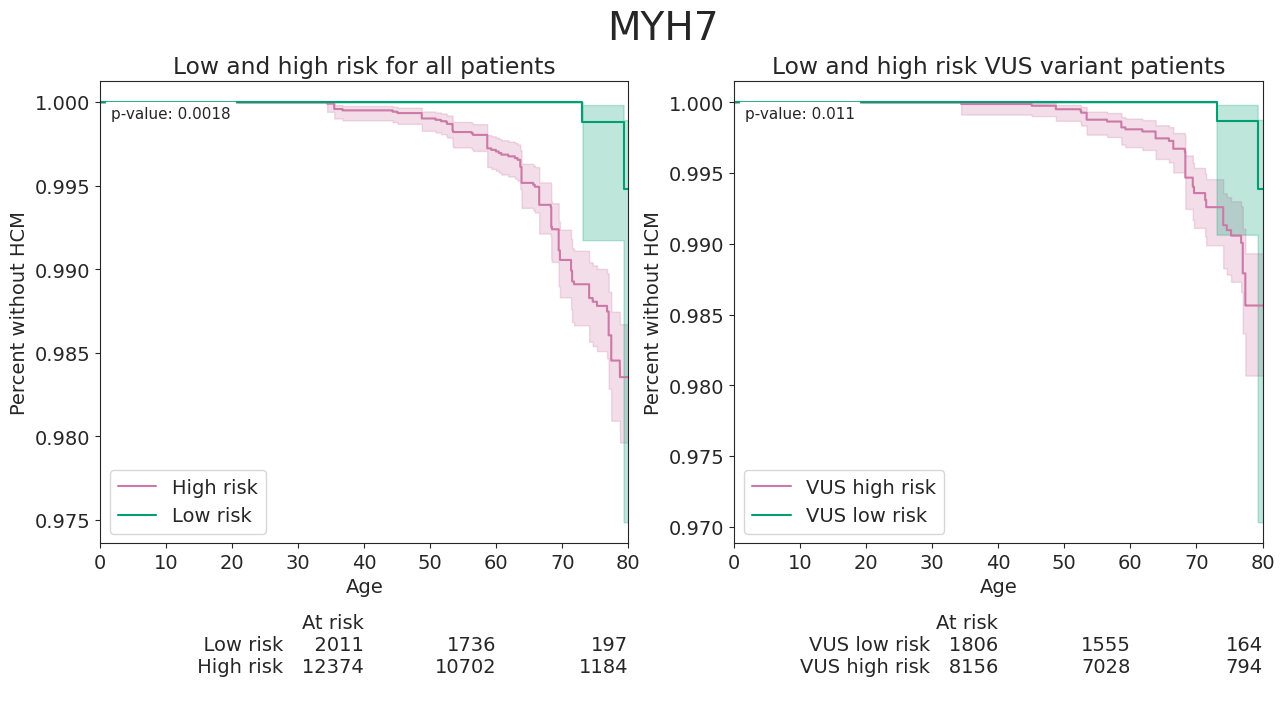

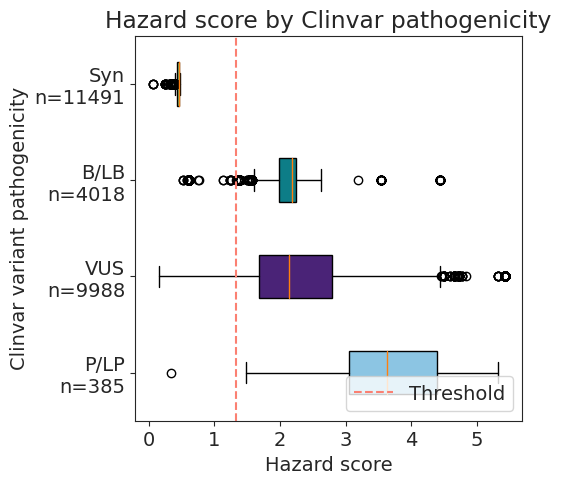

MYL2
Model with only variant-level features
Threshold list:  [30, 30, 30, 30, 30]
Number of HCM cases in non-synonymous: 54
Threshold by percentile:  30.0
Number of VUS above threshold:  6728


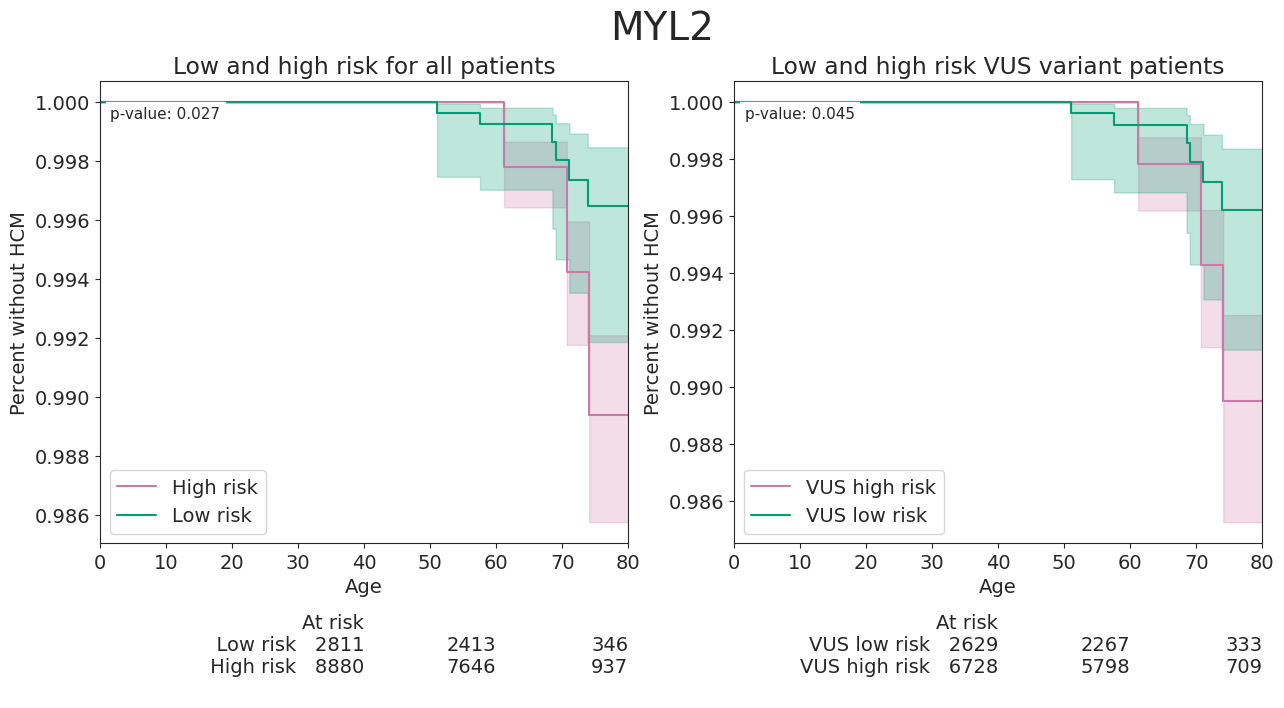

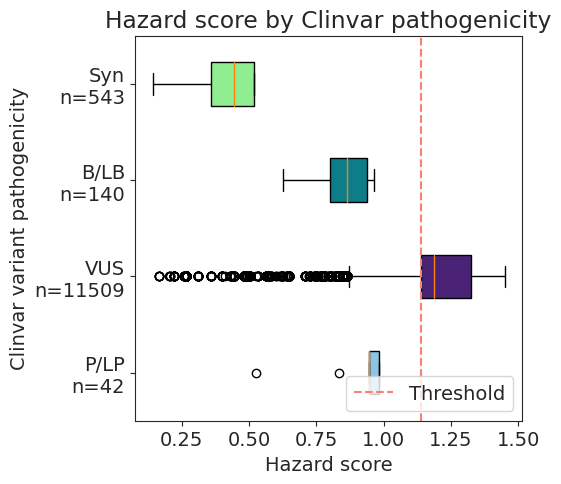

MYL3
Model with only variant-level features
Too few cases
PLN
Model with only variant-level features
Too few cases
PTPN11
Model with only variant-level features
Too few cases
TPM1
Model with only variant-level features
Too few cases
TNNI3
Model with only variant-level features
Threshold list:  [48, 49, 48, 47, 48]
Number of HCM cases in non-synonymous: 14
Threshold by percentile:  48.0
Number of VUS above threshold:  324


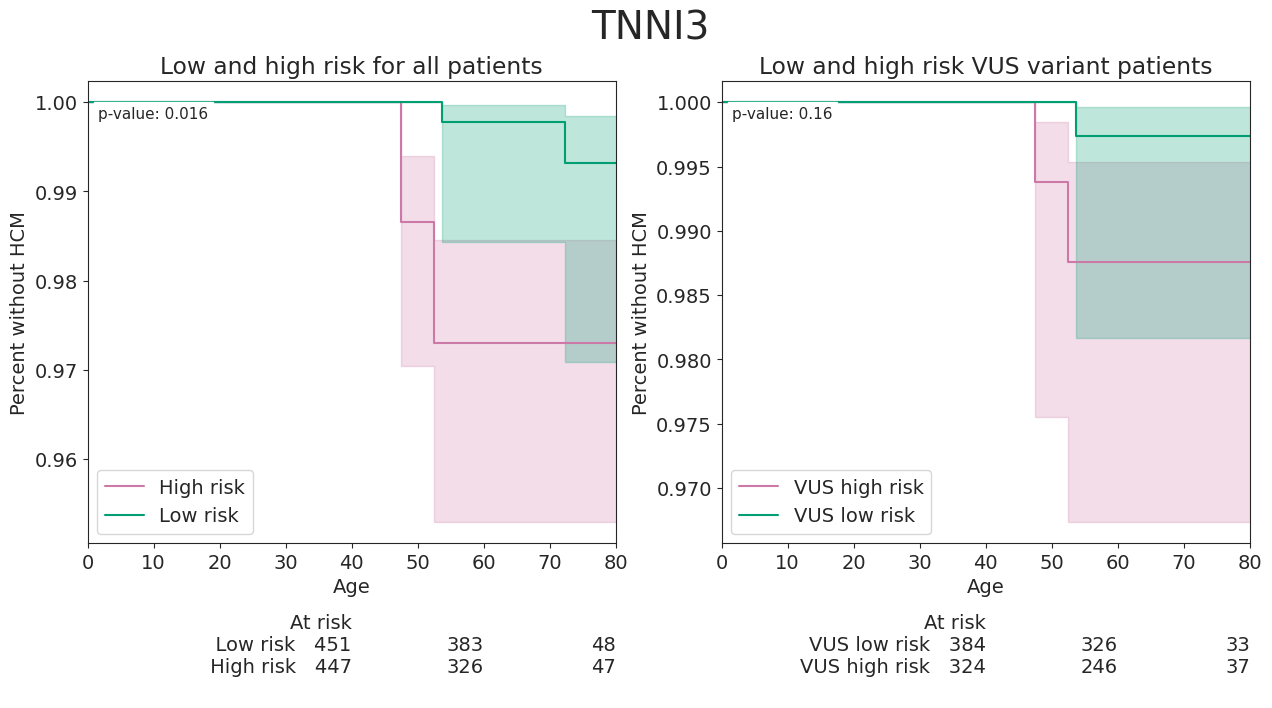

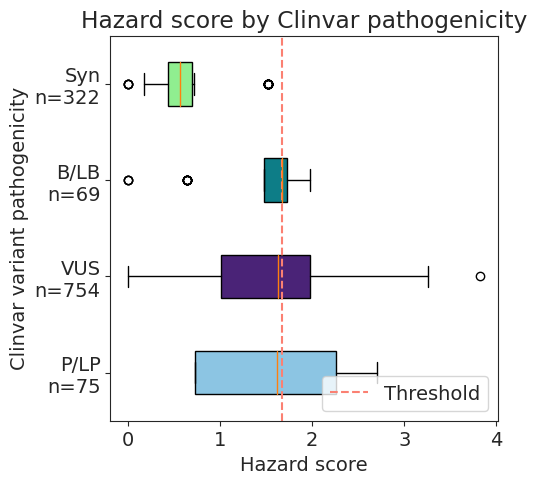

TNNT2
Model with only variant-level features
Threshold list:  [3, 4, 4, 4, 4]
Number of HCM cases in non-synonymous: 13
Threshold by percentile:  3.8
Number of VUS above threshold:  3627


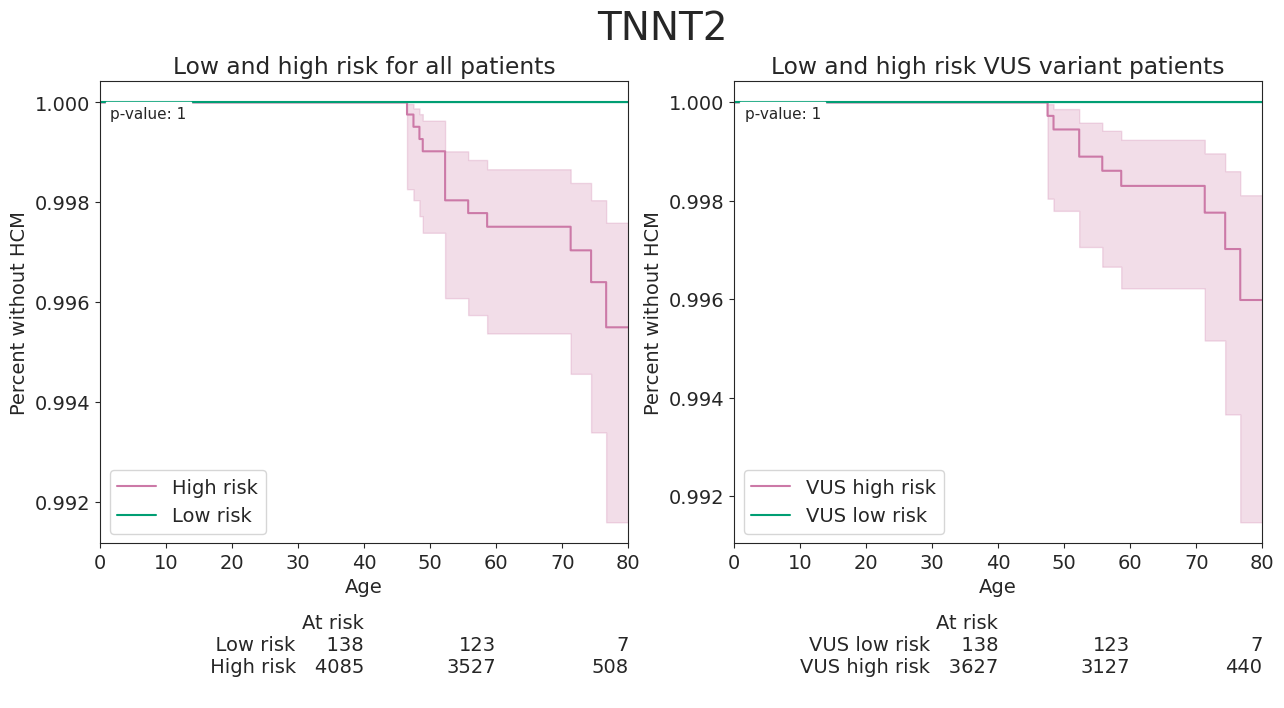

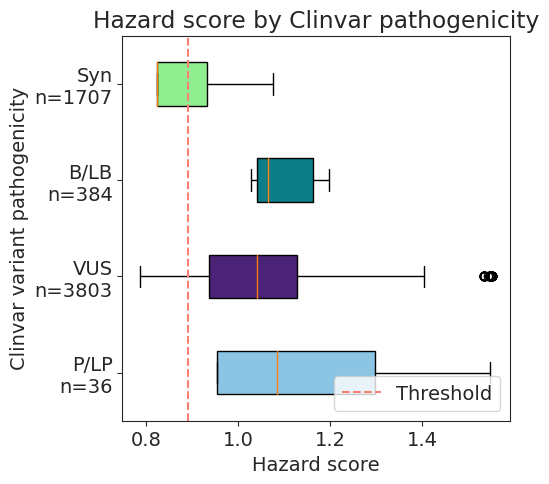

TRIM63
Model with only variant-level features
Too few cases
TTR
Model with only variant-level features
Too few cases


In [39]:
gene_list = ['ACTC1','ACTN2','ALPK3','CSRP3','DES','FHOD3','FLNC','JPH2','MYBPC3','MYH6','MYH7','MYL2','MYL3','PLN','PTPN11','TPM1','TNNI3','TNNT2','TRIM63','TTR']
find_threshold_vals(gene_list, only_variant_info = True)

ACTC1
Model with all features
Too few cases
ACTN2
Model with all features
Threshold list:  [72, 73, 72, 73, 77]
Number of HCM cases in non-synonymous: 13
Threshold by percentile:  73.4
Number of VUS above threshold:  1969


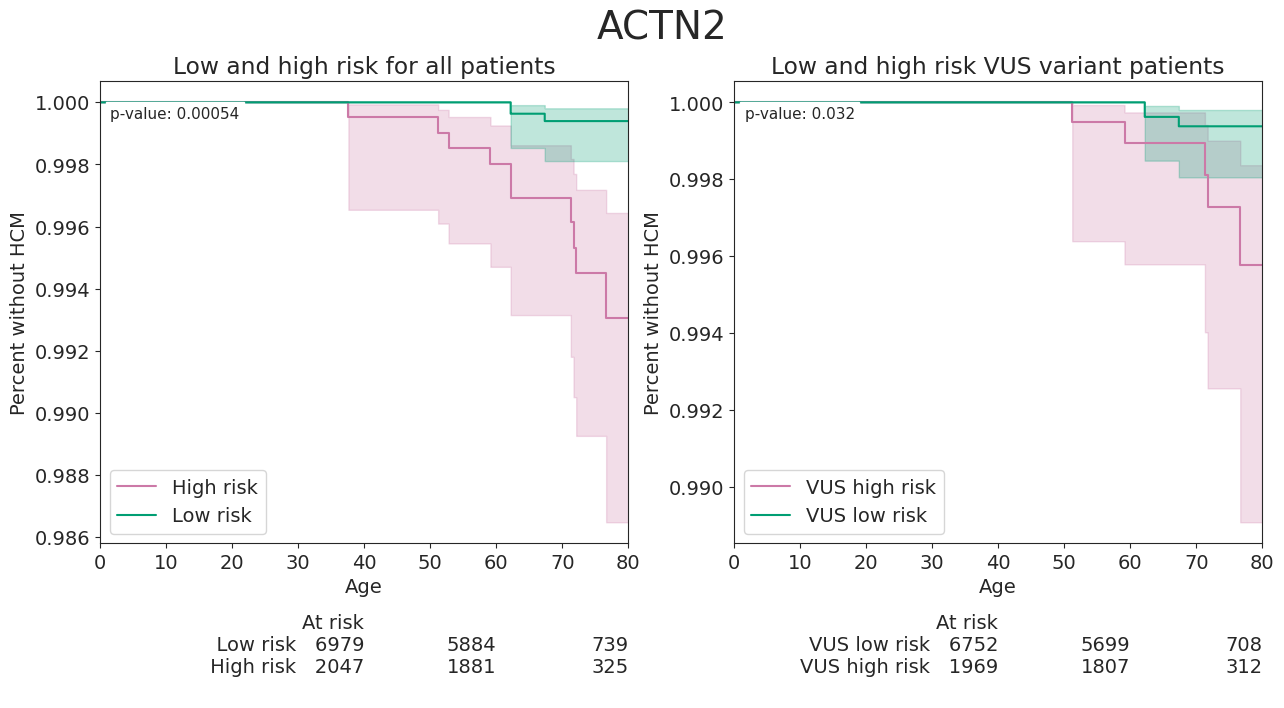

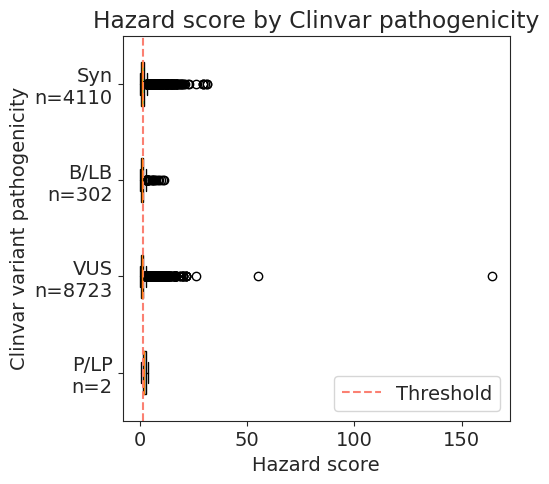

ALPK3
Model with all features
Threshold list:  [73, 73, 68, 65, 68]
Number of HCM cases in non-synonymous: 78
Threshold by percentile:  69.4
Number of VUS above threshold:  7320


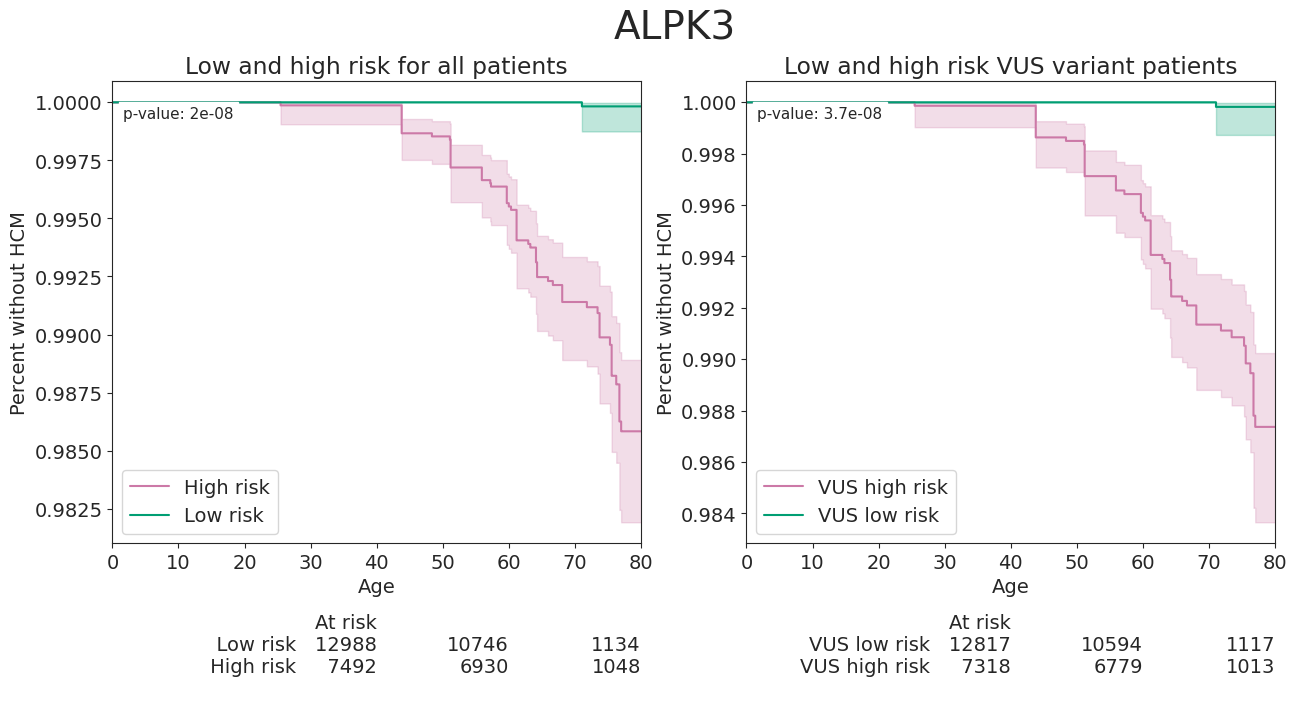

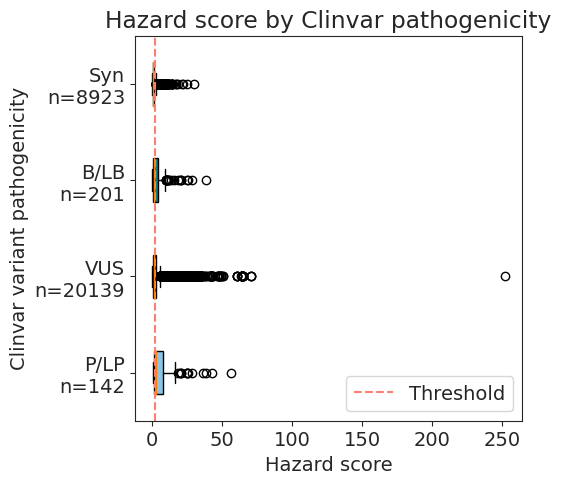

CSRP3
Model with all features
Threshold list:  [85, 85, 85, 50, 84]
Number of HCM cases in non-synonymous: 10
Threshold by percentile:  77.8
Number of VUS above threshold:  659


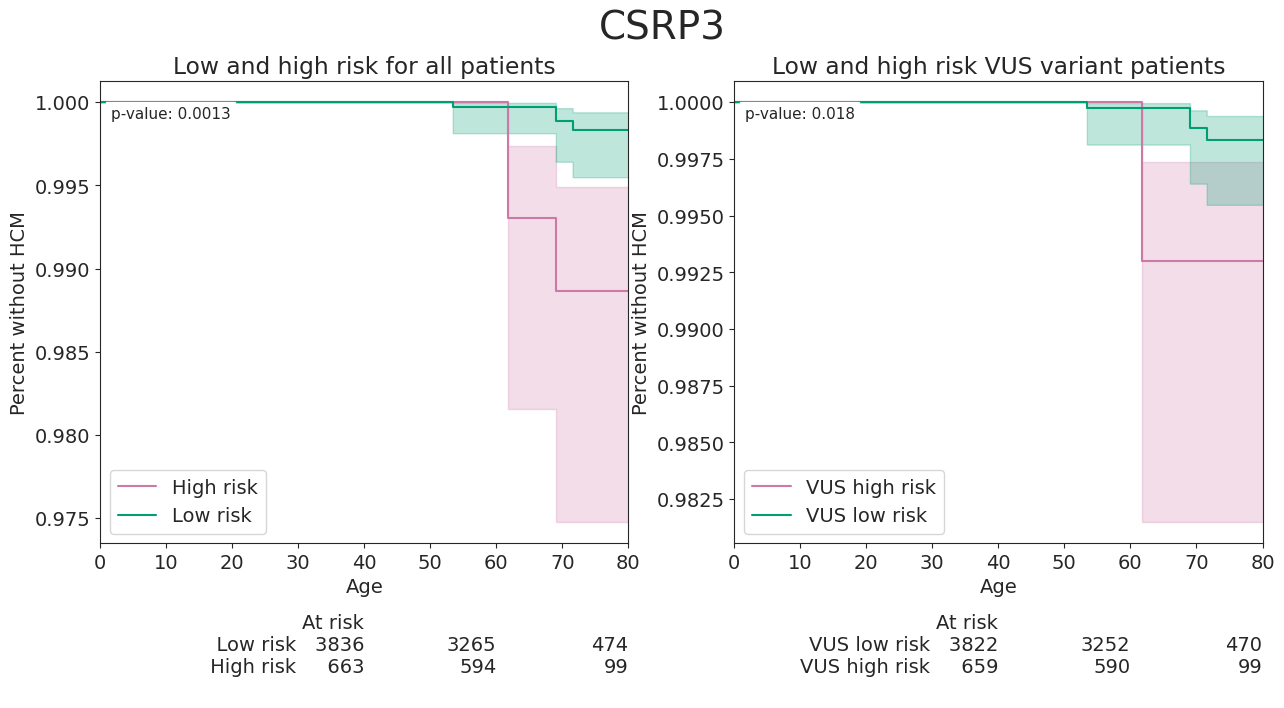

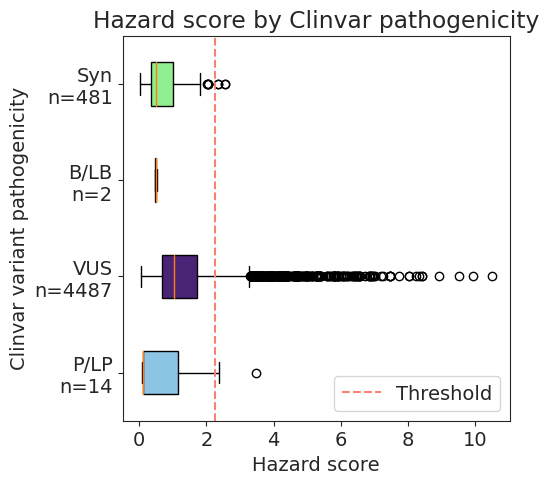

DES
Model with all features
Too few cases
FHOD3
Model with all features
Threshold list:  [50, 50, 50, 50, 62]
Number of HCM cases in non-synonymous: 35
Threshold by percentile:  52.4
Number of VUS above threshold:  4966


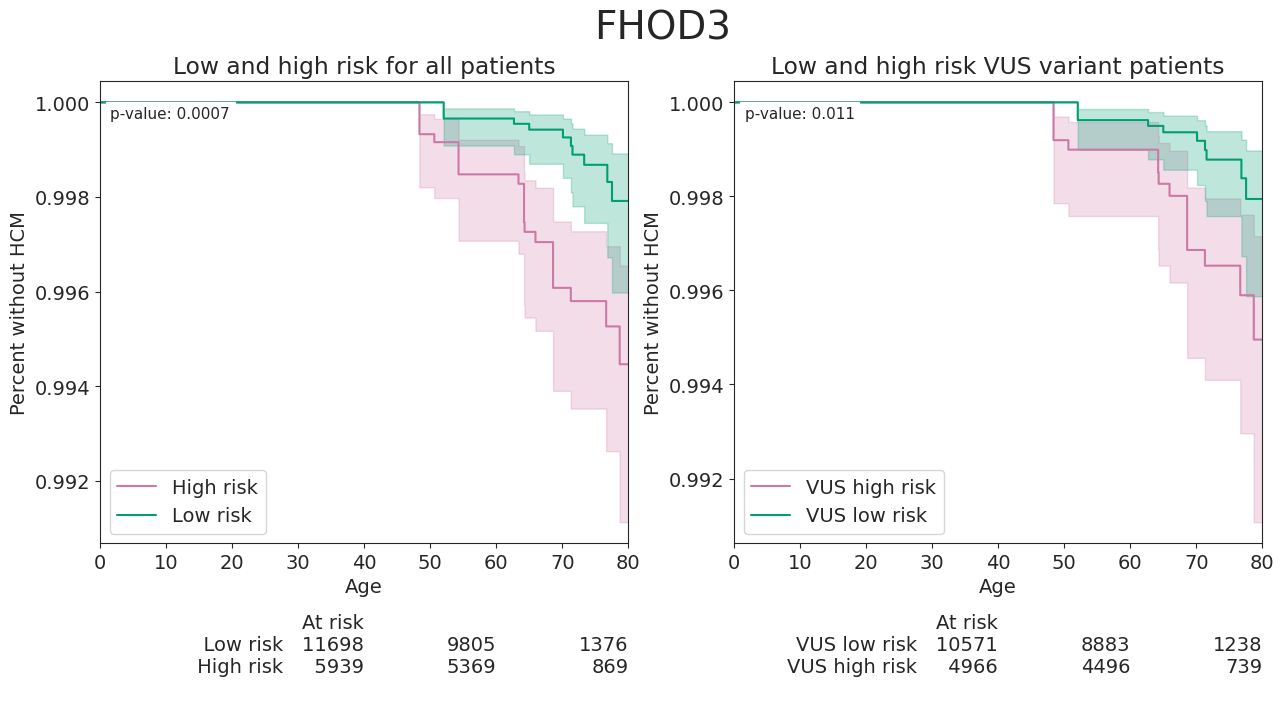

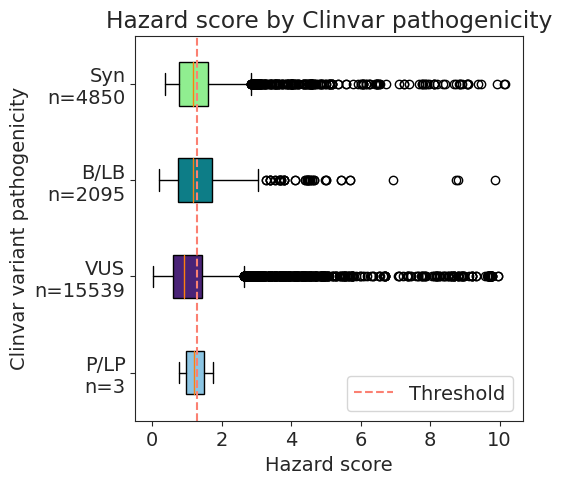

FLNC
Model with all features
Threshold list:  [95, 95, 96, 95, 96]
Number of HCM cases in non-synonymous: 62
Threshold by percentile:  95.4
Number of VUS above threshold:  614


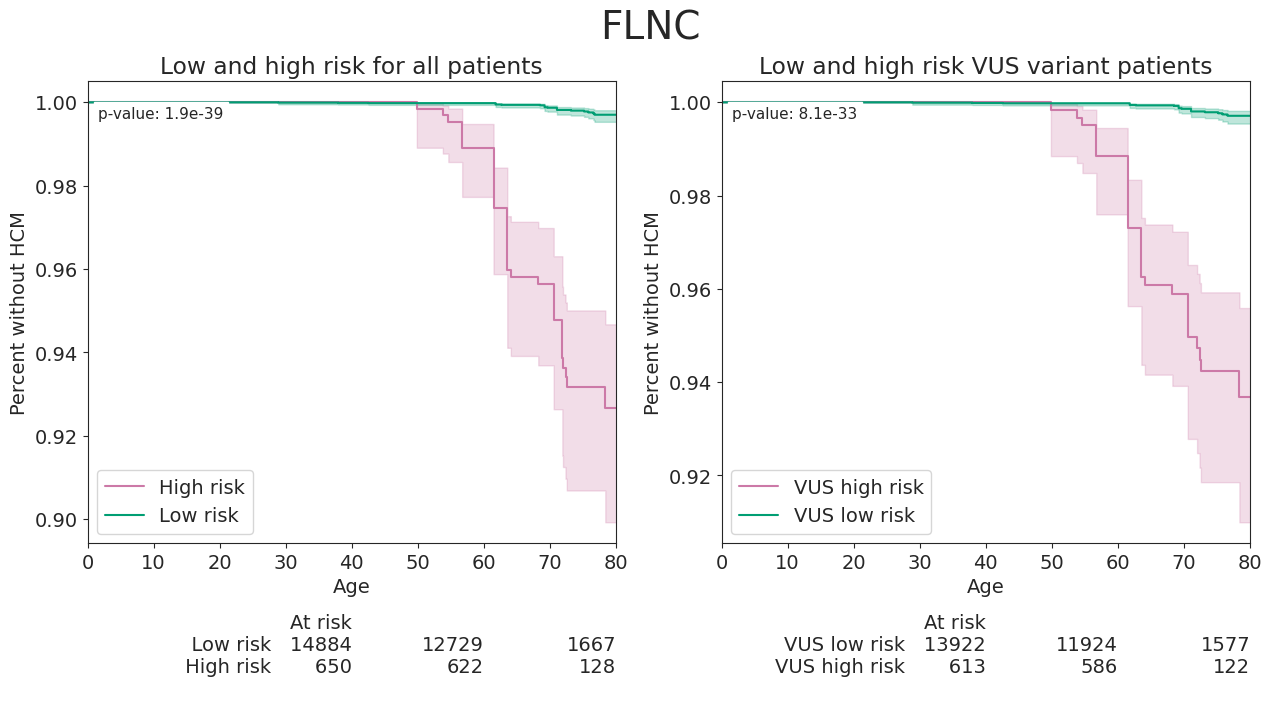

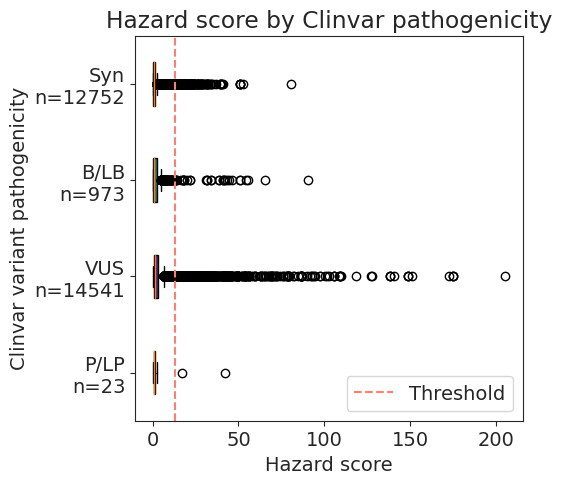

JPH2
Model with all features
Too few cases
MYBPC3
Model with all features
Threshold list:  [92, 92, 92, 92, 92]
Number of HCM cases in non-synonymous: 325
Threshold by percentile:  92.0
Number of VUS above threshold:  2976


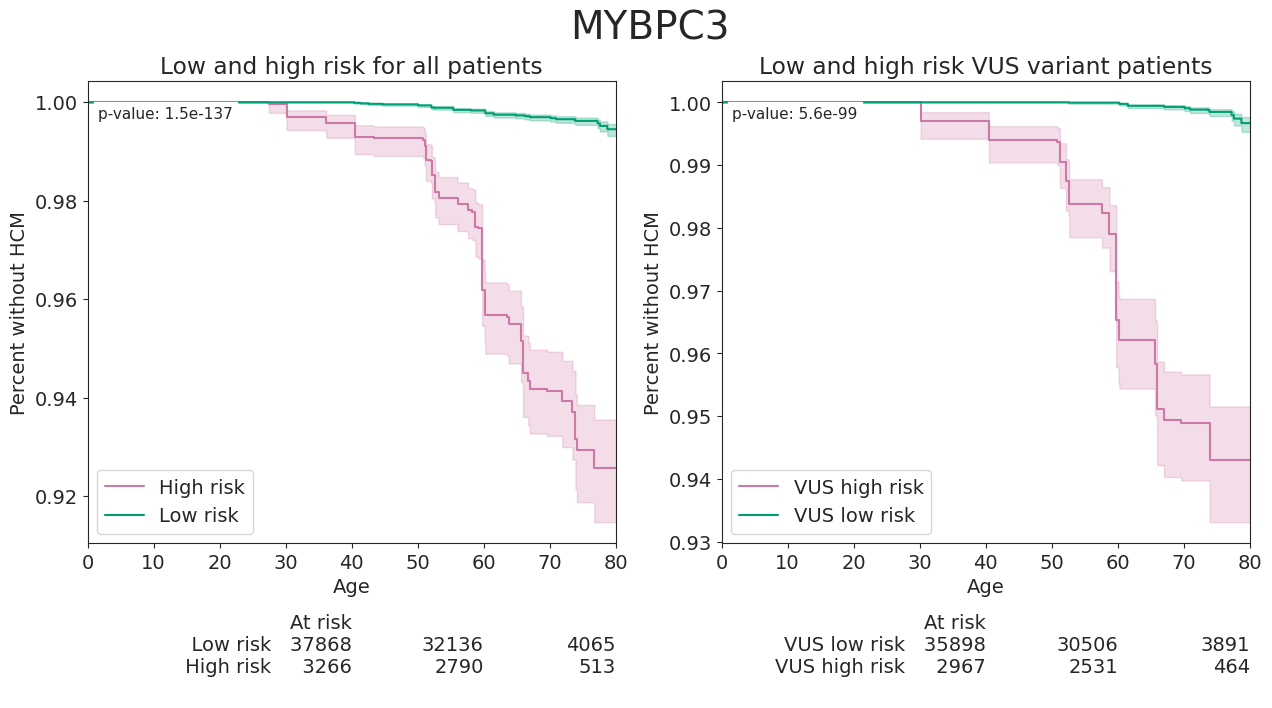

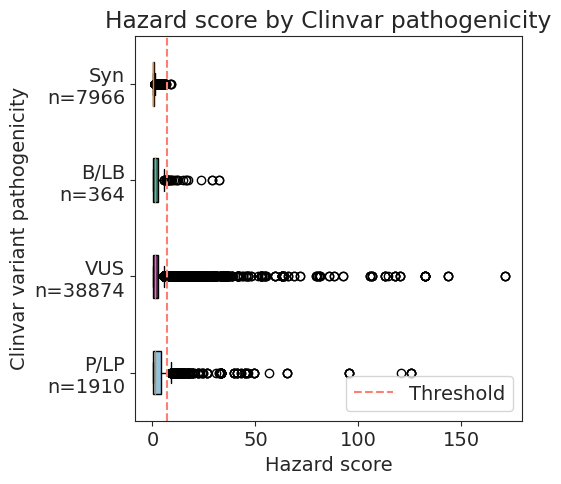

MYH6
Model with all features
Threshold list:  [82, 82, 82, 83, 92]
Number of HCM cases in non-synonymous: 25
Threshold by percentile:  84.2
Number of VUS above threshold:  1185


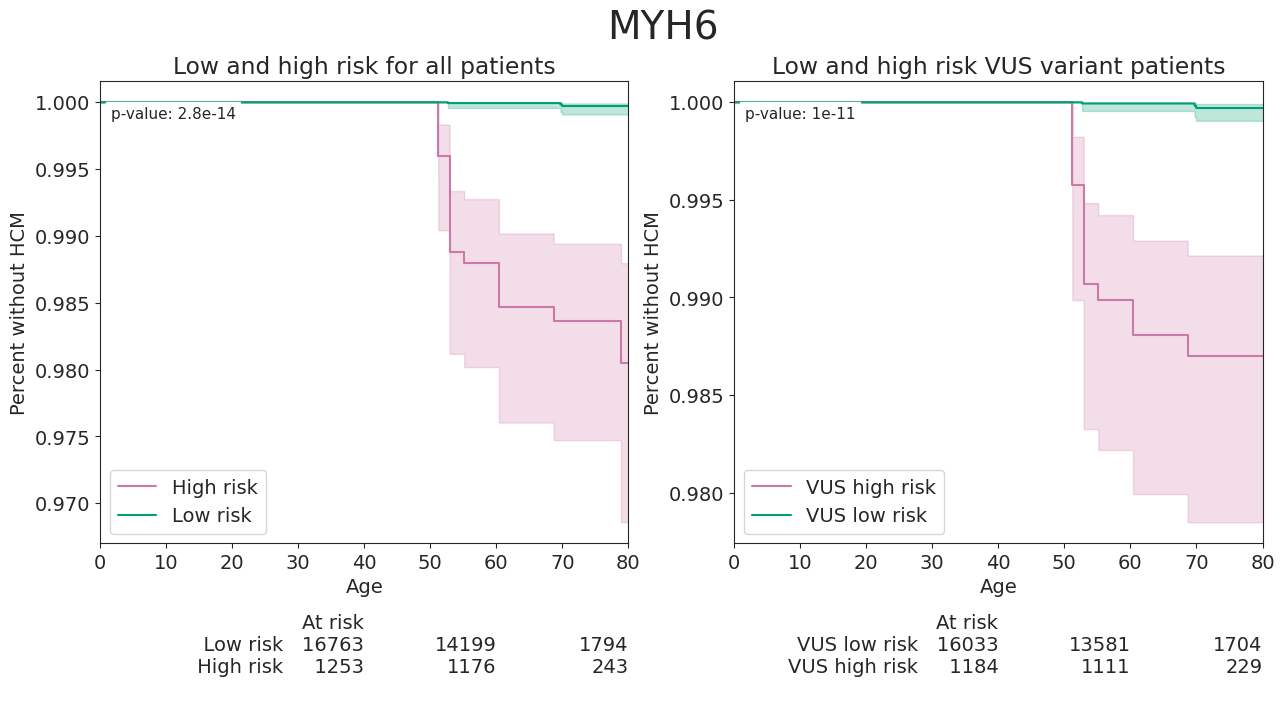

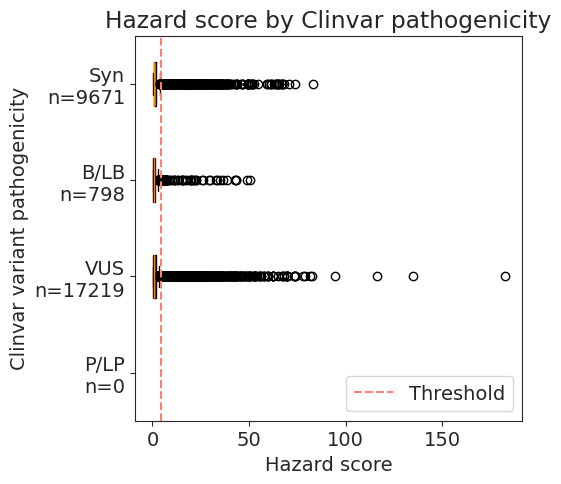

MYH7
Model with all features
Threshold list:  [79, 79, 78, 79, 79]
Number of HCM cases in non-synonymous: 117
Threshold by percentile:  78.8
Number of VUS above threshold:  2090


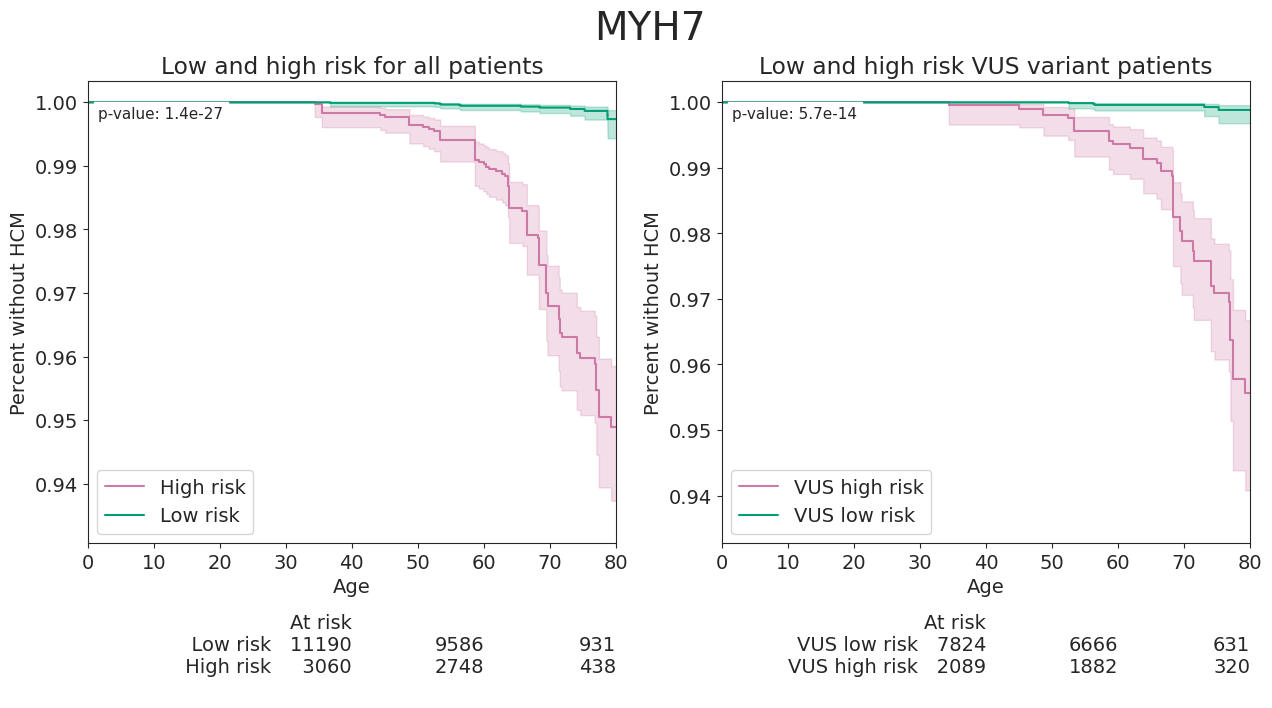

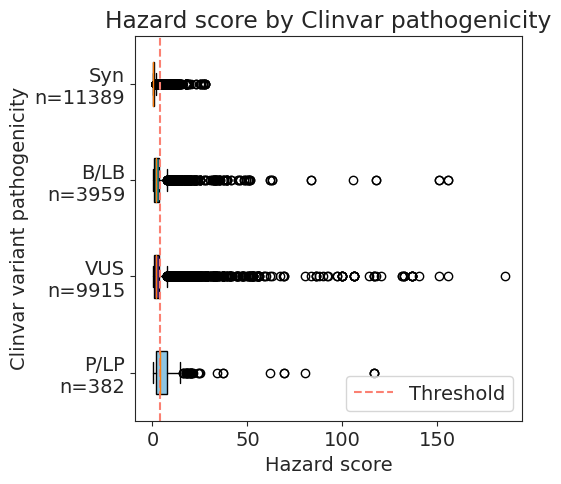

MYL2
Model with all features
Threshold list:  [89, 89, 88, 89, 88]
Number of HCM cases in non-synonymous: 54
Threshold by percentile:  88.6
Number of VUS above threshold:  1229


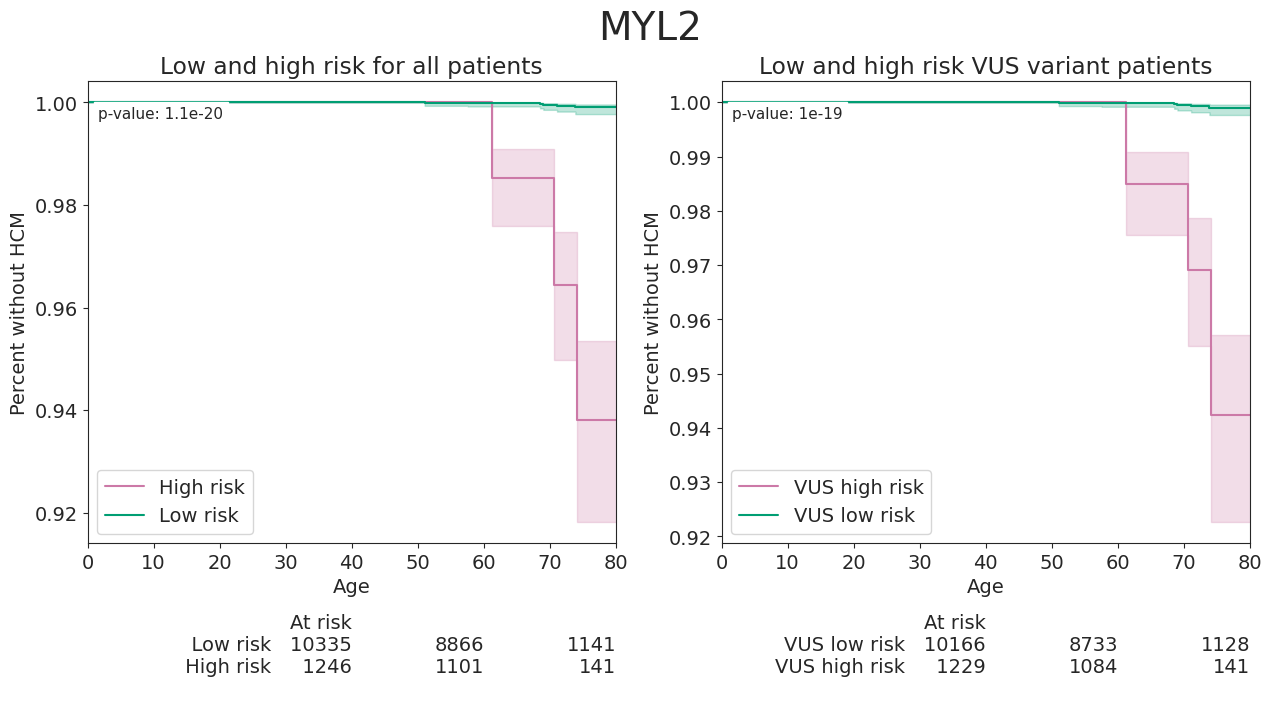

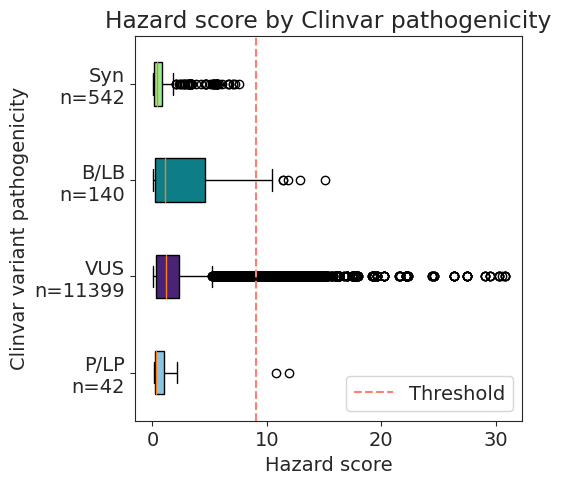

MYL3
Model with all features
Too few cases
PLN
Model with all features
Too few cases
PTPN11
Model with all features
Too few cases
TPM1
Model with all features
Too few cases
TNNI3
Model with all features
Threshold list:  [70, 68, 78, 77, 77]
Number of HCM cases in non-synonymous: 14
Threshold by percentile:  74.0
Number of VUS above threshold:  137


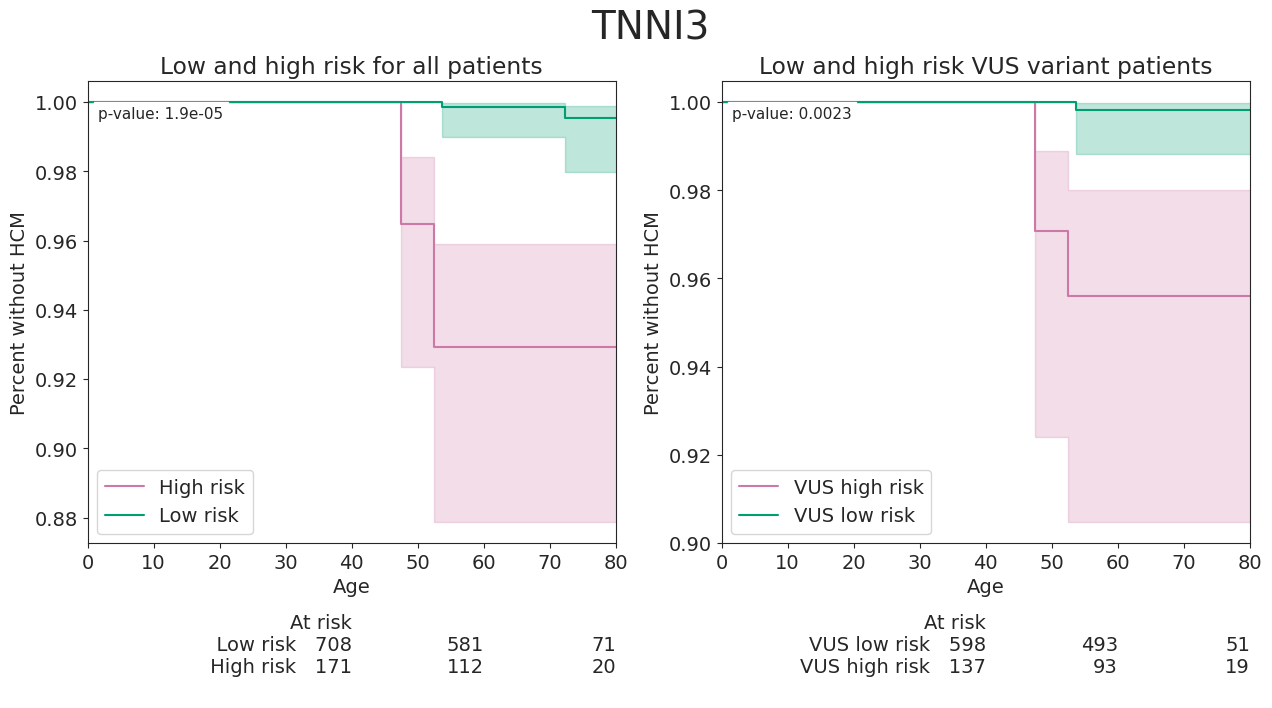

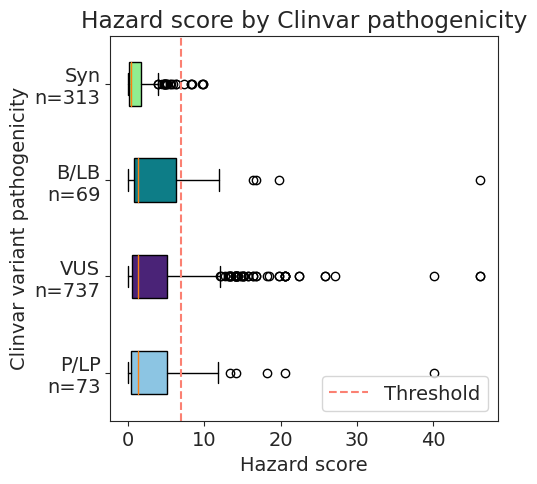

TNNT2
Model with all features
Threshold list:  [77, 85, 77, 78, 77]
Number of HCM cases in non-synonymous: 13
Threshold by percentile:  78.8
Number of VUS above threshold:  957


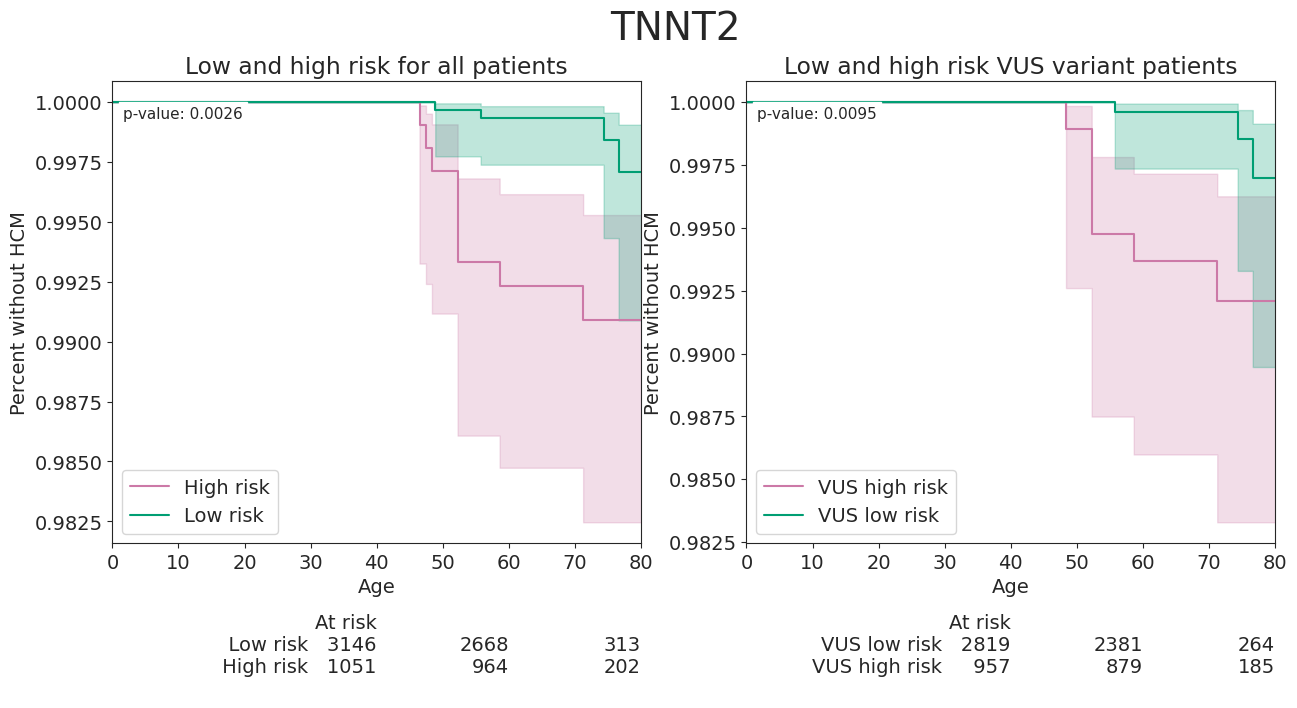

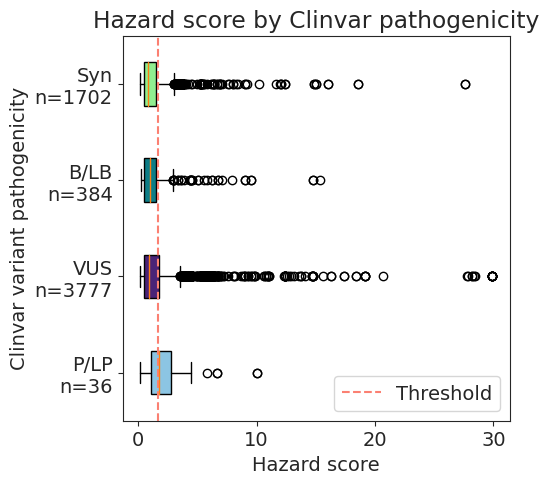

TRIM63
Model with all features
Too few cases
TTR
Model with all features
Too few cases


In [40]:
find_threshold_vals(gene_list)

In [12]:
def pathogenic_benign_graphs(lifelines_data_vus_high, lifelines_data_pathogenic, lifelines_data_vus_low, lifelines_data_benign):
    # PATHOGENIC
    kmf_vus_high = KaplanMeierFitter(label = 'VUS high risk')
    kmf_vus_high.fit(lifelines_data_vus_high['duration'], lifelines_data_vus_high['is_HCM'])
    kmf_vus_high.plot(color = '#CC79A7')

    kmf_pathogenic = KaplanMeierFitter(label = 'P/LP')
    kmf_pathogenic.fit(lifelines_data_pathogenic['duration'], lifelines_data_pathogenic['is_HCM'])
    kmf_pathogenic.plot(color = '#009E73')

    plt.title('P/LP and high risk VUS variants')
    plt.ylabel('Percent without HCM')
    plt.xlabel('Duration')


    dfA = pd.DataFrame({'E': lifelines_data_pathogenic['is_HCM'], 'T': lifelines_data_pathogenic['duration'], 'is_highest': 0})
    dfB = pd.DataFrame({'E': lifelines_data_vus_high['is_HCM'], 'T': lifelines_data_vus_high['duration'], 'is_highest': 1})
    df = pd.concat([dfA, dfB])
    try:
        cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
        results = "{:.{}g}".format(cph.summary['p'].at['is_highest'], 2)
    except:
        print("No convergence")
        return 

    plt.figtext(0.15, 0.75,'p-value: '+str(results), backgroundcolor = 'white')

    plotting.add_at_risk_counts(kmf_vus_high, kmf_pathogenic, rows_to_show = ['At risk'], xticks = [40, 60, 80])
    plt.xlim(0,80)

    plt.show()

    # BENIGN
    kmf_vus_low = KaplanMeierFitter(label = 'VUS low risk')
    kmf_vus_low.fit(lifelines_data_vus_low['duration'], lifelines_data_vus_low['is_HCM'])
    kmf_vus_low.plot(color = '#CC79A7')


    kmf_benign = KaplanMeierFitter(label = 'B/LB')
    kmf_benign.fit(lifelines_data_benign['duration'], lifelines_data_benign['is_HCM'])
    kmf_benign.plot(color = '#009E73')

    plt.title('B/LB and low risk VUS variants')
    plt.ylabel('Percent without HCM')
    plt.xlabel('Duration')

    # HERE
    dfA = pd.DataFrame({'E': lifelines_data_vus_low['is_HCM'], 'T': lifelines_data_vus_low['duration'], 'is_highest': 0})
    dfB = pd.DataFrame({'E': lifelines_data_benign['is_HCM'], 'T': lifelines_data_benign['duration'], 'is_highest': 1})
    df = pd.concat([dfA, dfB])
    cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
    results = "{:.{}g}".format(cph.summary['p'].at['is_highest'], 2)
    plt.figtext(0.15, 0.75,'p-value: '+str(results), backgroundcolor = 'white', )

    plt.xlim(0,80)
    plotting.add_at_risk_counts(kmf_vus_low, kmf_benign, rows_to_show = ['At risk'], xticks = [40, 60, 80])
    plt.show()
